## Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Read the data
df = pd.read_csv('train.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
df.dropna(axis=0, subset=['SalePrice'], inplace=True)

X =df.copy()
y = X.pop('SalePrice')

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
# Check if 'YearRemodAdd' is in your DataFrames
print('YearRemodAdd' in X_train_full.columns)
print('YearRemodAdd' in X_valid_full.columns)

# If it's missing, you'll need to investigate where it was dropped or if it was a typo.
# If it's a typo, correct the column name in your num_cols or cat_cols lists.

# If the column is present in X_valid_full but not in X_train_full,
# you may need to adjust your feature engineering steps to ensure consistency.

False
True


## Expole the data

In [ ]:
df.shape

(1460, 80)

In [ ]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [ ]:
#Check if test data has any missing rows

# Read the test data
test_df = pd.read_csv('test.csv', index_col='Id')

# Get missing columns in the training data
missing_cols = set(df.columns) - set(test_df.columns)

print(missing_cols)

{'SalePrice'}


In [ ]:
#Find much missing values does each row have
df.isnull().sum().sort_values(ascending=False).head(10)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [ ]:
deleted_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
for col in deleted_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in Alley: [nan 'Grvl' 'Pave']
Unique values in PoolQC: [nan 'Ex' 'Fa' 'Gd']
Unique values in Fence: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Unique values in MiscFeature: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


## Feature Engineering

In [ ]:
X_train_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def feature_engineering(df):
  df['HouseAge'] = df['YrSold'] - df['YearBuilt']
  df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
  df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
  df['YrSold_cat'] = df['YrSold'].astype(str)
  df['MoSold_cat'] = df['MoSold'].astype(str)
  df['Alley'] = df['Alley'].fillna('NoAlley')
  df['Alley_cat'] = df['Alley'].astype(str)

  df.drop([
      'YrBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
      'YrSold', 'MoSold', 'Alley', 'MiscFeature', 'PoolQC', 'Fence'
  ], axis=1, inplace=True, errors='ignore')

  return df

feature_eng = FunctionTransformer(feature_engineering)

## Data Preprocessing

## Define Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# Base Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(n_estimators=100, random_state=0)


num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = num_cols.drop('SalePrice')

# Transformers
numerical_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
transform = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols),
],sparse_threshold=0)

#Preprosessor
preprosessor = Pipeline(steps=[
    ('feature_eng', feature_eng),
    ('transform', transform),
    ('PCA', PCA(n_components=0.95)),
])

#pipeline
ModelPipeline = Pipeline(steps=[
    ('preprosessor', preprosessor),
    ('model', model)
])


## Base Prediction

In [ ]:
from sklearn.metrics import mean_absolute_error

print(X_train_full.columns)

X_train_prosessed = preprosessor.fit_transform(X_train_full)
X_valid_prosessed = preprosessor.transform(X_valid_full)

ModelPipeline.fit(X_train_prosessed, y_train)
preds = ModelPipeline.predict(X_valid_prosessed)

mae = mean_absolute_error(y_valid, preds)

print('MAE:', mae)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

ValueError: A given column is not a column of the dataframe

In [ ]:
ModelPipeline_fe.fit(X_train_full, y_train)
preds = ModelPipeline.predict(X_valid_full)

mae = mean_absolute_error(y_valid, preds)

print('MAE:', mae)

ValueError: A given column is not a column of the dataframe

## Neural Network Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - loss: 181296.8125 - mae: 181296.8125 - val_loss: 181369.5312 - val_mae: 181369.5312
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 182082.4844 - mae: 182082.4844 - val_loss: 181368.2188 - val_mae: 181368.2188
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 180581.4062 - mae: 180581.4062 - val_loss: 181365.1875 - val_mae: 181365.1875
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 181220.7812 - mae: 181220.7812 - val_loss: 181358.5156 - val_mae: 181358.5156
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 179813.8281 - mae: 179813.8281 - val_loss: 181345.0156 - val_mae: 181345.0156
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 179919.0156 - mae: 179919.0156 - val_loss: 181320.8438 - val_mae: 181320.8438
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 180938.4688 - mae: 180938.4688 - val_loss: 181282.2812 - val_mae: 181282.2812
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1

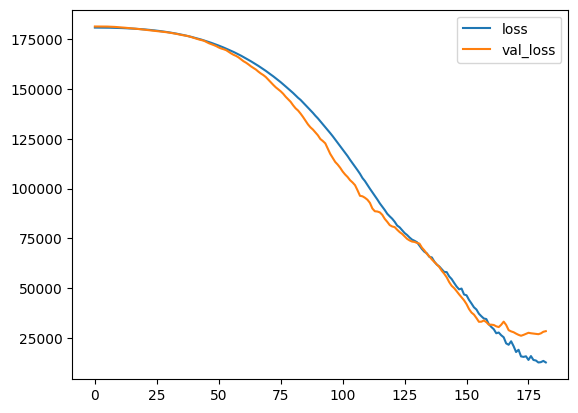

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

model_nw = keras.Sequential([
    layers.Dense(600, input_shape=[X_train.shape[1]]),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(600, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(600, activation='relu'),
    layers.Dense(1)
])

model_nw.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

X_train = preprosessor.fit_transform(X_train_full)
X_valid = preprosessor.transform(X_valid_full)

history = model_nw.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))